In [1]:
import torch  
import torch.nn as nn
import multiprocessing 
import numpy as np 
from tqdm import tqdm 

from datasets import load_dataset

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms as T

/Users/alessandrozirilli/Progetti/crypto-playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("ylecun/mnist")

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])


def apply_transform(batch):
    images = batch["image"]
    batch["image"] = [transform(img) for img in images]
    return batch

ds.set_transform(apply_transform)

In [3]:
from torch.utils.data import DataLoader

def collate_fn(batch):

    images = [item["image"] for item in batch]
    labels = [item["label"] for item in batch]

    images = torch.stack(images)

    labels = torch.tensor(labels, dtype=torch.long)

    return images, labels

train_loader = DataLoader(
    ds["train"],
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn
)


test_loader = DataLoader(
    ds["test"],
    batch_size=256,
    shuffle=False,
    collate_fn=collate_fn
)

In [4]:
from crypto.modules.mlp import SimpleMLP

model = SimpleMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [5]:
import matplotlib.pyplot as plt

def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

# Train on MNIST or Skip to next Section

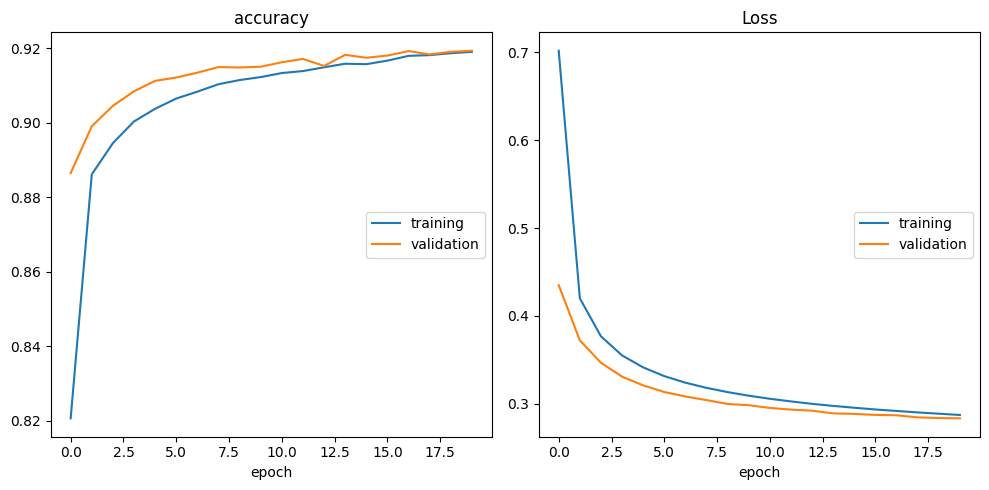

Epochs: 100%|███████████████████████████████████| 20/20 [01:08<00:00,  3.44s/it]

Saved last model to 'last_model.pth'
Restored best model with Validation Loss: 0.2834


In [6]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import torch
import copy 
from tqdm import tqdm

n_epochs = 20
model_run_count = 0

liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot, figsize=(10, 5))])
logs = {}

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in tqdm(
            range(n_epochs),
            desc="Epochs",
            total=n_epochs,
            leave=True,
            ncols=80,
        ):
    
    model.train() 
    train_loss = 0.0
    train_correct = 0  

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        
        pred = output.argmax(dim=1, keepdim=True) 
        train_correct += pred.eq(target.view_as(pred)).sum().item()

    average_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset) 

    with torch.no_grad():
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
            pred = output.argmax(dim=1, keepdim=True)
            valid_correct += pred.eq(target.view_as(pred)).sum().item()

        average_valid_loss = valid_loss / len(test_loader.dataset)
        valid_acc = valid_correct / len(test_loader.dataset) 
    
    logs['loss'] = average_train_loss
    logs['val_loss'] = average_valid_loss
    logs['accuracy'] = train_acc         
    logs['val_accuracy'] = valid_acc     

    liveloss.update(logs)
    liveloss.send()

    if average_valid_loss < best_val_loss:
        best_val_loss = average_valid_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")

torch.save(model.state_dict(), "last_model.pth")
print("Saved last model to 'last_model.pth'")

model.load_state_dict(best_model_wts)
print(f"Restored best model with Validation Loss: {best_val_loss:.4f}")

In [7]:
best_model_wts= torch.load("best_model.pth")

model.load_state_dict(best_model_wts)

<All keys matched successfully>

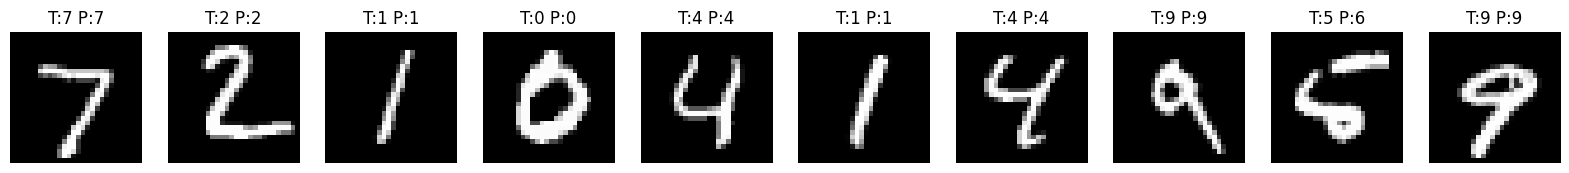

In [8]:
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

data_iter = iter(test_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)

outputs = model(images)
preds = outputs.argmax(dim=1)

images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax = axes[i]
    img = images[i].squeeze() 
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{labels[i]} P:{preds[i]}")
    ax.axis('off')

plt.show()